Naive variational message passing demo
===

ForneyLab comes with support for variational message passing (VMP). Variational methods often involve complicated and extensive derivations. VMP on a factor graph eases our derivation troubles by expressing the variational algorithm in terms of local update rules. In his 2007 article, Dauwels gives a generic introduction to VMP on a factor graph. ForneyLab implements this VMP approach.

In this demo we illustrate VMP by estimating the mean and variance of samples drawn from a Gaussian distribution. The factor graph below shows our generative model. We observe the samples $y = \{y_1, ..., y_k, ..., y_n\}$ and wish to estimate the posterior distribution over the mean and variance given these samples. We use the factor graph notation of (Reller, 2012; State-space methods in statistical signal processing) where filled black nodes represent observed variables and dotted arcs denote the repetition of a section.

<img src="images/gauss_est.png">

For estimation we use a variational message passing algorithm with a mean field factorized distribution over our variables $q(m,s,y) = q(m)\,q(s)\,q(y)$.

We start by building the graph.

In [1]:
using(ForneyLab)

# Initial settings
n_samples      = 20 # Number of observed samples
n_its          = 50 # Number of vmp iterations
true_mean      = 5.0
true_variance  = 2.0
y_observations = sqrt(true_variance)*randn(n_samples) + true_mean # y observation buffer

# Pre-assign arrays for later reference
g_nodes    = Array(GaussianNode, n_samples)
m_eq_nodes = Array(EqualityNode, n_samples)
s_eq_nodes = Array(EqualityNode, n_samples)
y_nodes    = Array(TerminalNode, n_samples)

# Build graph
for section=1:n_samples
    g_nodes[section] = GaussianNode(id="g$(section)")
    m_eq_nodes[section] = EqualityNode() # Equality node chain for mean
    s_eq_nodes[section] = EqualityNode() # Equality node chain for variance
    y_nodes[section] = TerminalNode(DeltaDistribution(y_observations[section]), id="y$(section)") # Observed y values are stored in terminal node values
    Edge(g_nodes[section].i[:out], y_nodes[section], GaussianDistribution)
    Edge(m_eq_nodes[section].i[3], g_nodes[section].i[:mean], GaussianDistribution)
    Edge(s_eq_nodes[section].i[3], g_nodes[section].i[:variance], InverseGammaDistribution)
    if section > 1 # Connect sections
        Edge(m_eq_nodes[section-1].i[2], m_eq_nodes[section].i[1], GaussianDistribution)
        Edge(s_eq_nodes[section-1].i[2], s_eq_nodes[section].i[1], InverseGammaDistribution)
    end
end
# Attach beginning and end nodes
m_0 = PriorNode(GaussianDistribution(m=0.0, V=100.0)) # Prior
s_0 = PriorNode(InverseGammaDistribution(a=0.01, b=0.01)) # Prior
m_N = TerminalNode(vague(GaussianDistribution)) # Uninformative distribution
s_N = TerminalNode(vague(InverseGammaDistribution)) # Uninformative distribution
Edge(m_0, m_eq_nodes[1].i[1], GaussianDistribution)
Edge(s_0, s_eq_nodes[1].i[1], InverseGammaDistribution)
Edge(m_eq_nodes[end].i[2], m_N, GaussianDistribution)
Edge(s_eq_nodes[end].i[2], s_N, InverseGammaDistribution);

Next we need to specify the variational inference procedure. This sounds like a lot of work, but it can be accomlished automatically.

In [2]:
# Specify some write buffers
m_out = setWriteBuffer(m_N.i[:out].partner)
s_out = setWriteBuffer(s_N.i[:out].partner)

# Specify the variational algorithm for n_its vmp iterations
algo = VMP.Algorithm(n_iterations=n_its)

Algorithm with fields:
 q_distributions::Dict{(Node,Subgraph),QDistribution}
 factorization::QFactorization
 n_iterations::Int64

Use algorithm.fields[:field] to inspect field values.


Under the hood, the `VMP.Algorithm()` constructor performs a mean field factorization, generates a schedule towards wraps and write buffers, and initializes vague q-distributions.

We can visualize a subgraph of one factor with the `draw(::Subgraph)` function. The external edges of the subgraph are then denoted by red dashed arrows. 


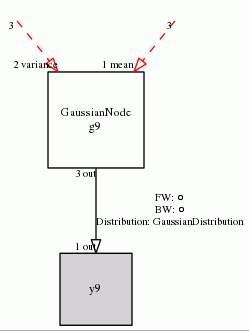

In [3]:
draw(algo.fields[:factorization].factors[3])

Now we can iteratively execute these schedules and inspect the results. 

In [4]:
step(algo)

# Inspect the results
println("True mean: $(true_mean)")
println("True variance: $(true_variance)")
println("Number of samples: $(length(y_observations))")
println("Sample mean: $(round(mean(y_observations),2))")
println("Sample variance: $(round(var(y_observations),2))")
println("\n----- Estimation after $(n_its) VMP updates -----")
println("Mean estimate: $(round(mean(m_out[end])[1],2)), with variance $(round(var(m_out[end])[1, 1],2))")
println("Variance estimate: $(round(mean(s_out[end]),2)), with variance $(round(var(s_out[end]),2))")

True mean: 5.0
True variance: 2.0
Number of samples: 20
Sample mean: 5.0
Sample variance: 3.26

----- Estimation after 50 VMP updates -----
Mean estimate: 5.0, with variance 0.02
Variance estimate: 3.46, with variance 1.5
